In [1]:
# Import all the necessary packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from ark.utils import spatial_analysis_utils, io_utils  # noqa: E402
from ark.analysis import spatial_analysis, visualize

# Read data

In [2]:
# Set up file paths and import data
base_dir = "../data/example_dataset/"
spatial_analysis_dir = os.path.join(base_dir, "spatial_enrichment_input_data")

In [3]:
# validate file paths (add other directories as needed)
io_utils.validate_paths([
    base_dir,
    spatial_analysis_dir,
])

In [4]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes, and cell phenotype IDs.
all_data = pd.read_csv(os.path.join(spatial_analysis_dir, "example_expression_matrix.csv"))

In [5]:
# This is the Xarray of label maps for multiple fovs from which the distance matrix will be computed
label_maps = xr.load_dataarray(os.path.join(spatial_analysis_dir, "segmentation_labels.xr"))

# Get dictionary object with the respective distance matrices for the fovs
dist_mats = spatial_analysis_utils.calc_dist_matrix(label_maps)

# Compute neighborhood analysis

In [6]:
# Now with the same inputs, we will run a neighborhood analysis to determine counts for clusters of cells of different phenotypes. 
neighbor_counts, neighbor_freqs = spatial_analysis.create_neighborhood_matrix(all_data, dist_mats, distlim=50)

# Find optimal k for k-means clustering

In [7]:
# can use neighbor_freqs as well, default max_k chosen will be 10, metric computed is silhouette score
neighbor_silhouette_scores = spatial_analysis.compute_cluster_metrics(neighbor_counts)

Use the elbow curve method to choose the optimal k

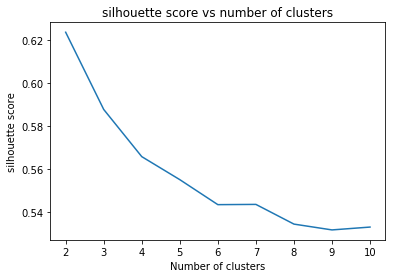

In [8]:
visualize.visualize_neighbor_cluster_metrics(neighbor_silhouette_scores)

# Generate cluster results

In [9]:
# set k value here based on results from graph above
k = None

In [10]:
# need to drop the label col prior to clustering
neighbor_counts = neighbor_counts.drop(columns='cellLabelInImage')

In [11]:
# Columns, other than the marker columns, in the expression data
# These columns will be excluded from the analysis, so that a matrix of only markers can be extracted
excluded_colnames = ["SampleID", "cellLabelInImage", "cellSize", "C", "Na", "Si", "Background", "HH3",
                     "Ta", "Au", "Tissue", "PatientID", "lineage", "cell_type",
                     "cell_lin", "lintype_num", "FlowSOM_ID"]

In [12]:
all_data_cluster_labeled, num_cell_type_per_cluster, mean_marker_exp_per_cluster = \
    spatial_analysis.generate_cluster_matrix_results(
        all_data, neighbor_counts, cluster_num=k, excluded_colnames=excluded_colnames)

# Overlay segmentation with neighborhood clusters

TODO: add visualization to do this

# Write expression matrix with cluster labels to csv

In [ ]:
# do this once you're satisfied with the clusters you've been assigned
all_data_cluster_labeled.to_csv(os.path.join(spatial_analysis_dir, "example_expression_matrix_clustered.csv"))